In [1]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.keras.utils import plot_model

In [2]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
cd /content/drive

/content/drive


In [5]:
cd MyDrive


/content/drive/MyDrive


In [6]:
cd 'data for colab'

/content/drive/MyDrive/data for colab


In [7]:
data=pd.read_csv("hot_topics_data_100K.csv")

In [ ]:
#data=data.iloc[:1000,]

In [8]:
data.shape

(100000, 3)

In [9]:
test=pd.read_csv("test_set_2000.csv")

In [10]:
#Remove test from data
data=data[~(data["FINDINGS"].isin(test["FINDINGS"])&data["IMPRESSION"].isin(test["IMPRESSION"]))]

In [ ]:
data.shape

(96503, 3)

In [11]:
#Drop duplicates
data.drop_duplicates(subset=['FINDINGS'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

In [12]:
#drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['FINDINGS']:
    cleaned_text.append(text_cleaner(t))

In [15]:
cleaned_text_test = []
for t in test['FINDINGS']:
    cleaned_text_test.append(text_cleaner(t))

In [16]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['IMPRESSION']:
    cleaned_summary.append(summary_cleaner(t))
#Call the above function
cleaned_summary_test = []
for t in test['IMPRESSION']:
    cleaned_summary_test.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

test['cleaned_text']=cleaned_text_test
test['cleaned_summary']=cleaned_summary_test
test['cleaned_summary'].replace('', np.nan, inplace=True)
test.dropna(axis=0,inplace=True)

In [17]:
#Add the START and END special tokens at the beginning and end of the summary
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')
#Add the START and END special tokens at the beginning and end of the summary
test['cleaned_summary'] = test['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

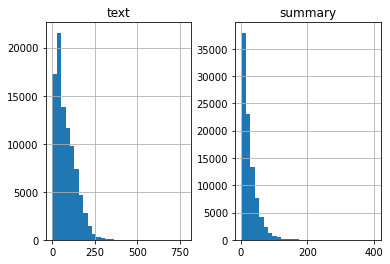

In [18]:
#analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [19]:
#From above histogram we define
max_len_text=200 
max_len_summary=54

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


In [21]:
x_test=test["cleaned_text"]
y_test=test["cleaned_summary"]

In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [23]:
x_test=x_tokenizer.texts_to_sequences(x_test)
x_test   =   pad_sequences(x_test, maxlen=max_len_text, padding='post')

In [24]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [25]:
y_test= y_tokenizer.texts_to_sequences(y_test)
y_test   =   pad_sequences(y_test, maxlen=max_len_summary, padding='post')

In [26]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2) 

#LSTM 4 
encoder_lstm4=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_output4, state_4, state_4= encoder_lstm4(encoder_output3) 

#LSTM 5 
encoder_lstm5=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm5(encoder_output4) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_output1,decoder_fwd_state1, decoder_back_state2 = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#LSTM2 
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm2(decoder_output1, initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     9730000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 500), ( 2002000     lstm[0][0]                       
_______________________________________________________________________________________

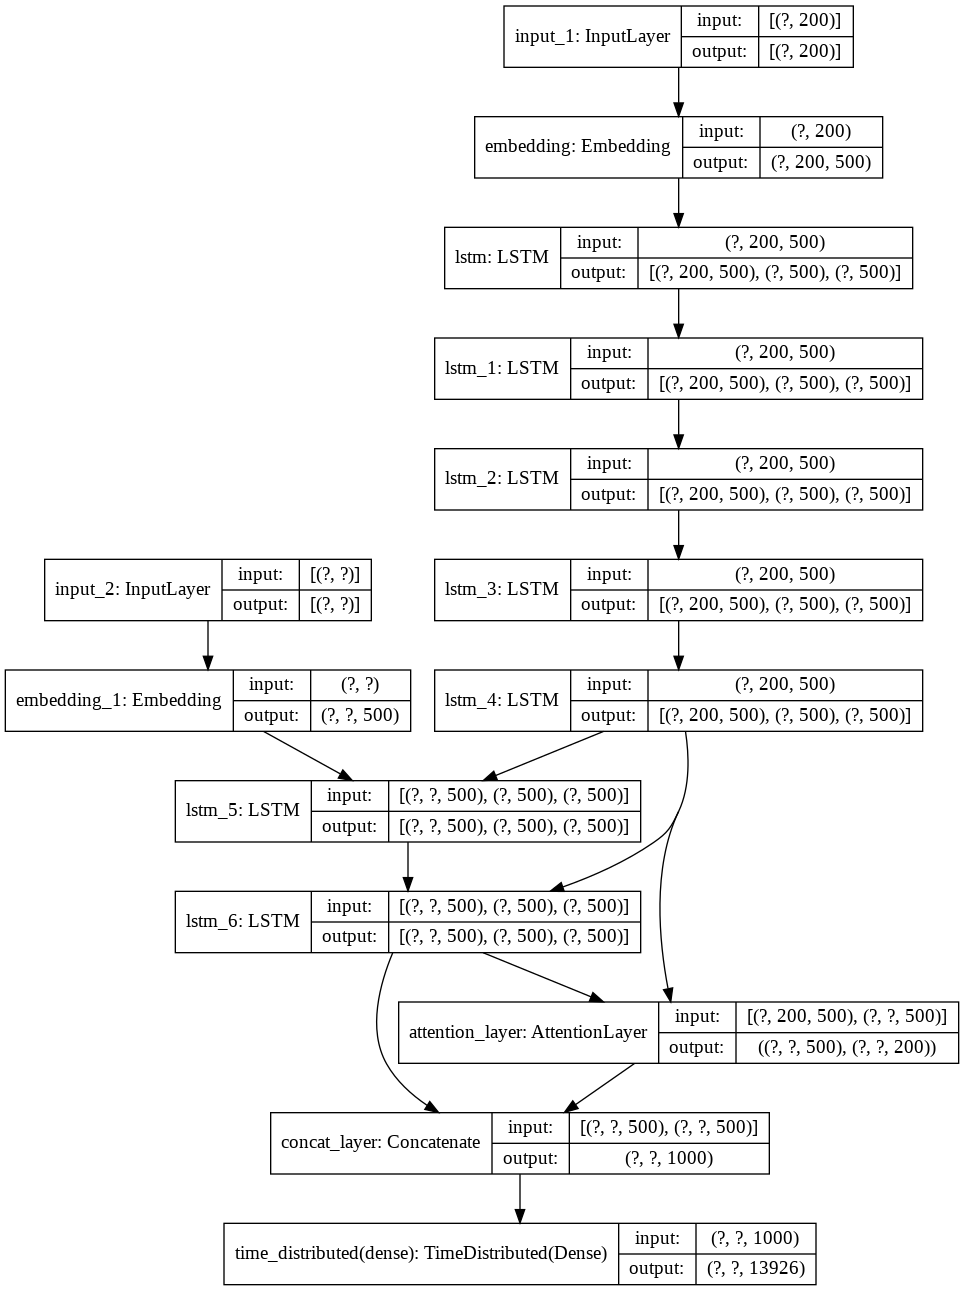

In [ ]:
plot_model(model,show_shapes=True)

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [29]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], callbacks=[es],epochs=15,batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/15
1288/1288 [==============================] - 525s 408ms/step - loss: 1.9514 - val_loss: 1.4829
Epoch 2/15
1288/1288 [==============================] - 522s 405ms/step - loss: 1.4036 - val_loss: 1.3290
Epoch 3/15
1288/1288 [==============================] - 520s 404ms/step - loss: 1.2815 - val_loss: 1.2577
Epoch 4/15
1288/1288 [==============================] - 521s 404ms/step - loss: 1.2097 - val_loss: 1.2195
Epoch 5/15
1288/1288 [==============================] - 518s 402ms/step - loss: 1.1546 - val_loss: 1.2005
Epoch 6/15
1288/1288 [==============================] - 519s 403ms/step - loss: 1.1076 - val_loss: 1.1883
Epoch 7/15
1288/1288 [==============================] - 520s 404ms/step - loss: 1.0641 - val_loss: 1.1830
Epoch 8/15
1288/1288 [==============================] - 519s 403ms/step - loss: 1.0221 - val_loss: 1.1867
Epoch 9/15
1288/1288 [==============================] - 520s 404ms/step - loss: 0.9788 - val_loss: 1.1863
Epoch 00009: early stopping


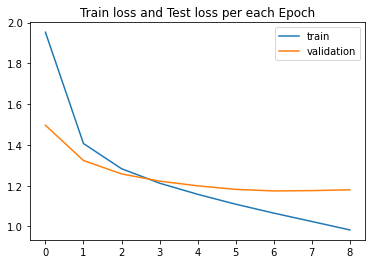

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title("Train loss and Test loss per each Epoch")
pyplot.legend()
pyplot.show()

In [30]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [31]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs3, state_h3, state_c3 = decoder_lstm2(decoder_outputs2, initial_state=[decoder_state_input_h, decoder_state_input_c])
#decoder_outputs3, state_h3, state_c3 = decoder_lstm2(decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]))

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs3])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs3, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs3 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs3] + [state_h3, state_c3])


In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
       
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
      
        # Sample a token

        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index==0:
          stop_condition=True
          continue

        sampled_token = reverse_target_word_index[sampled_token_index]
      
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= 54-1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
decode_sequence(x_test[750].reshape(1,max_len_text))

' no evidence of the chest and no evidence of prior right subclavian the chest of personally'

In [ ]:
b

' no evidence of the chest and no evidence of prior right subclavian the chest of personally'

In [ ]:
seq2summary(y_test[8])

'no specific evidence of infection or edema '

In [ ]:
test.iloc[750,:]["cleaned_summary"]

'sostok normal examination  eostok'

In [33]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
y_test.shape

(2000, 54)

In [34]:
y_true=[]
y_pred=[]
for i in range(0,2000):
  print(i)
  y_true.append(seq2summary(y_tr[i]))
  y_pred.append(decode_sequence(x_tr[i].reshape(1,max_len_text)))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
pred_output=pd.DataFrame()
pred_output["y_pred"]=y_pred
pred_output["y_true"]=y_true

In [ ]:
pred_output.head()

,y_pred,y_true,bleu1,bleu2,rouge1,rouge2
0,interval increase in the left frontal tempora...,status post embolization of left cerebellar ar...,0.228428,0.021327,0.258824,0.024096
1,no acute intracranial hemorrhage or acute fin...,no intracranial hemorrhage or hydrocephalus pl...,0.295844,0.104778,0.324324,0.114286
2,mild interstitial lung and mild to the right ...,chronic appearing interstitial opacities with ...,0.037736,1.000000,0.064516,0.000000
3,basilar atelectasis of the left lower abdomin...,left central venous catheter terminates in the...,0.134909,0.028569,0.204082,0.042553
4,right frontal temporal and right temporal and...,interval stable intraparenchymal hemorrhage su...,0.054881,0.548812,0.076923,0.000000


In [36]:

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

def sentence_bleu_n(ref, hyp, weights):
  return sentence_bleu(references = [ref.split()], 
                       hypothesis = hyp.split(),
                       weights = weights,
                       smoothing_function = chencherry.method1)

In [37]:
pip install rouge

In [38]:
from rouge import Rouge 

In [39]:
def sentence_rouge(ref, hyp,weight):
  rouge = Rouge()
  scores=rouge.get_scores(ref, hyp)
  if weight==1:
    return scores[0]["rouge-1"]["f"]
  else:
    return scores[0]["rouge-2"]["f"]

In [40]:
# bleu1
pred_output['bleu1'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [1,0,0,0]), axis=1)

# bleu2
pred_output['bleu2'] = pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_bleu_n(x[1], x[0], weights = [0,1,0,0]), axis=1)

#Rouge1
pred_output["rouge1"]=pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_rouge(x[1], x[0], weight = 1), axis=1)

#Rouge2
pred_output["rouge2"]=pred_output[['y_pred', 'y_true']].apply(lambda x: sentence_rouge(x[1], x[0], weight = 2), axis=1)

In [ ]:
pred_output.head(10)

,y_pred,y_true,bleu1,bleu2,rouge1,rouge2
0,right parietal lobe and brain and the right p...,subacute infarction involving the right poster...,0.122626,0.055182,0.222222,0.098361
1,interval increase in the right cerebellar tis...,over the interval previously demonstrated mode...,0.113208,1.000000,0.133333,0.000000
2,technically suboptimal examination with large...,no evidence of pulmonary embolism centrilobula...,0.153526,0.706222,0.185185,0.000000
3,enteric tube enteric tube and tongue the the ...,no change in appearance of enteric tube as abo...,0.117647,0.062500,0.121212,0.064516
4,no evidence of intracranial hemorrhage the br...,no evidence of intracranial hemorrhage or mass...,0.133774,0.070072,0.242424,0.125000
5,slight decrease in the size of the left lung ...,no change in the previously described left low...,0.256081,0.146857,0.268657,0.153846
6,findings of the left lower and left lower and...,diffuse colonic wall thickening with moderate ...,0.096154,1.000000,0.107527,0.000000
7,pancreatic necrosis and body and body of the ...,interval increase in peripancreatic fluid and ...,0.083464,0.730310,0.098765,0.000000
8,basilar atelectasis and the left lower and an...,no specific evidence of infection or edema,0.043478,1.000000,0.066667,0.000000
9,cardiomegaly with left sided chest and right ...,no acute cardiopulmonary disease left lower lo...,0.111111,0.058824,0.148148,0.080000


In [41]:
pred_output["bleu1"].mean()

0.17046155929819423

In [42]:
pred_output["bleu2"].mean()

0.0613668070762472

In [43]:
pred_output["rouge1"].mean()

0.22057160386432534

In [44]:
pred_output["rouge2"].mean()

0.07672210427560167

In [ ]:
for i in range(0,100):
    print(i)
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_len_text)))
    print("\n")

0
Review: diffusion restriction present involving right parietal lobe including superior inferior parietal lobules well adjacent right temporal lobe posterior aspect right superior temporal gyrus posterior aspect right insular cortex additional diffusion restriction present along right paracentral lobule posterior aspects right cingulate gyrus areas hyperintense flair mri adjacent cerebral swelling leptomeningeal enhancement mild degree periventricular subcortical punctate hyperintense white matter lesions present identified flair images susceptibility imaging low signal focus present along right orbital gyrus associated surrounding flair signal hyperintensity well associated signal hyperintensity significant contrast enhancement vascular flow voids present distal carotid vertebral arteries basilar artery proximal anterior middle posterior cerebral arteries well internal cerebral veins superior sagittal sinus visualized portions paranasal sinuses clear visualized portions mastoid air c

KeyboardInterrupt: ignored

In [ ]:
x_test[9].reshape(1,max_len_text)

array([[ 786,    3, 1798,  402,    4,  721, 1411,    4,  324,  482,  118,
         136,  196,  304, 1459,    4,   28,  318,   22,  117,   23,  443,
         588,  270,    9,   78,   40,  194,  349,  762,  186,   36,   52,
           5,   43,   18, 2327,   89,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 